In [1]:
# init the model
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-5-nano")

llm.invoke("Hi")

AIMessage(content='Hello! How can I help today? I can answer questions, explain topics, help with writing or editing, assist with coding or math, brainstorm ideas, plan things, and more. What would you like to do?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 181, 'prompt_tokens': 7, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CvzoFsfWRg6iDpkBj4XjZwmUigYmv', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019ba155-f47e-70d3-82be-0fdf1e9f1547-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 7, 'output_tokens': 181, 'total_tokens': 188, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

In [2]:
from langchain.tools import tool

@tool
def send_email(to:str, subject:str, content:str):
    """Send email to user with subject and content"""
    return f"Email has been send to user : {to} and subject : {subject} with content : {content}"

In [3]:
llm_with_tools = llm.bind_tools([send_email], tool_choice="any", parallel_tool_calls=False)

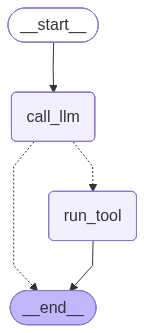

In [4]:
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import display, Image

def call_llm(state:MessagesState):
    return {"messages": llm_with_tools.invoke(state["messages"])}

def run_tool(state:MessagesState):
    out = send_email.invoke(state["messages"][-1].tool_calls[0]["args"])
    result = []
    result.append({"role": "tool", "content": out, "tool_call_id" :state["messages"][-1].tool_calls[0]["id"]})
    return {"messages": result}

def should_contnue(state:MessagesState):

    if state["messages"][-1].tool_calls:
        return "run_tool"
    else: 
        return END
    

graph = StateGraph(MessagesState)
# add node
graph.add_node("call_llm", call_llm)
graph.add_node("run_tool", run_tool)
# add edge
graph.add_edge(START,  "call_llm")
graph.add_conditional_edges("call_llm", should_contnue, {"run_tool": "run_tool", END:END})
graph.add_edge("run_tool", END)


# compile
graph = graph.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
graph.invoke({"messages": "Send an email to sam@gmail.com about tomoorrow meeting"})

{'messages': [HumanMessage(content='Send an email to sam@gmail.com about tomoorrow meeting', additional_kwargs={}, response_metadata={}, id='ede6000a-b46e-4563-9b54-5ec813bec088'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 710, 'prompt_tokens': 147, 'total_tokens': 857, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 640, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CvzoKS5F30Hb5t9RqIgjhJjeAVpWP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ba156-12bf-7f61-8b11-7d679f668b48-0', tool_calls=[{'name': 'send_email', 'args': {'to': 'sam@gmail.com', 'subject': "Reminder: Tomorrow's Meeting", 'content': 'Hi Sam,\n\nThis is a reminder about our meeting tom

In [6]:
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

In [7]:
author = email_input["author"]
to = email_input["to"]
subject = email_input["subject"]
email_thread = email_input["email_thread"]

In [8]:
author

'System Admin <sysadmin@company.com>'

In [9]:
from pydantic import BaseModel, Field
from typing import Literal
class RouterSchema(BaseModel):
    thought: str = Field("The thought process behind the classification")
    classsification : Literal["respond", "notify", "ignore"] = Field(description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply")

In [10]:
llm_with_structure = llm.with_structured_output(RouterSchema)

In [43]:
from rich.markdown import Markdown
user_prompt = f"""Please determine how to handle this email:\n
    author : {author}\n
    to : {to} \n
    subject : {subject} \n
    email_thread : {email_thread}
    """

In [45]:
res = llm_with_structure.invoke([{"role": "user", "content": user_prompt}])
res

RouterSchema(thought='Scheduled maintenance notice to Development Team; informs downtime and requests planning but does not require a direct reply.', classsification='notify')

In [47]:
res.classsification

'notify'

In [ ]:
class State(MessagesState):
    email_input: dict
    classification_decision: Literal["ignore", "notify", "respond"]

In [ ]:
format_email_markdown = f"""

**Subject**: {subject}
**From**: {author}
**To**: {to}

{email_thread}

---
"""

from langgraph.types import Command

def triage_router(state):
    # get the email inputs
    author = state[email_input["author"]]
    to = state[email_input["to"]]
    subject = state[email_input["subject"]]
    email_thread = state[email_input["email_thread"]]
        

    ## lets classify the emails input with_structute_output
    user_prompt = f"""Please determine how to handle this email:\n
    author : {author}\n
    to : {to} \n
    subject : {subject} \n
    email_thread : {email_thread}
    """
    response =  llm_with_structure.invoke([{"role": "user", "content":prompt}])

    if response.classsification == "notify":
        goto = END
        update = {
            "classification_decision" : response.classification
        }
    elif response.classsification == "ignore":
        goto = END
        update = {
            "classification_decision" : response.classification
        }     
    elif response.classsification == "respond":
        goto = "response-agent"
        update = {
            "classification_decision" : response.classification,
            "messages" : [
                {"role": "user", "content" : f"Respond to the email: \n\n{format_email_markdown.format(subject, author, to, email_thread)}"}
            ]
        }      
    else: 
        return ValueError(f"Invaid classifiction : {response.classification}")
    
    return Command(goto=goto, update=update)
    
    